# EDA

## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import warnings
import xgboost
import scipy.stats as stats
import pylab
warnings.filterwarnings('ignore')

## Importing Dataset

In [2]:
#importing dataset
airbnb=pd.read_csv("AB_NYC_2019.csv")

#looking at head
airbnb.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
#looking at number of rise to guage size of dataset - notably some values missing
airbnb.shape

(48895, 16)

In [4]:
#data types
airbnb.info

<bound method DataFrame.info of              id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

       

## Data Preprocessing

In [5]:
#removing duplicates
airbnb.duplicated().sum()
airbnb.drop_duplicates(inplace=True)

In [6]:
#checking how many null values in dataset for each column
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
#drop columns such as id, host name, and last review as there is no need to analyse the names of hosts. The last_review column is a date. This won't exist if thee number of reviews is 0 and will not be relevant to analysis. The name of the listing is also to be dropped as we will not be conducting NLP.

airbnb.drop(['id','name','host_name','last_review'], axis=1, inplace=True)
airbnb.head(5)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [8]:
#replace null values with 0
airbnb.fillna({'reviews_per_month':0}, inplace=True)
airbnb.reviews_per_month.isnull().sum()

0

In [9]:
airbnb.isnull().sum()
airbnb.dropna(how='any',inplace=True)
#remove any listings with price = 0
airbnb = airbnb[airbnb.price>0]


In [10]:
airbnb.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.090800,7.144628,112.779498
std,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.597213,32.956185,131.627271
min,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Visualisations for Variation and Covariation

### Correlation between variables

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

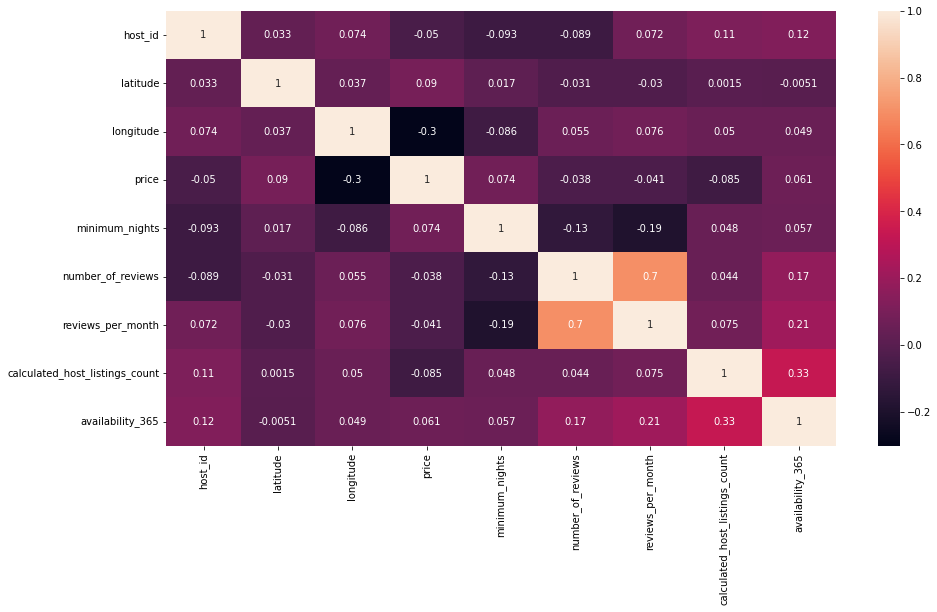

In [11]:
#correlation between variables

corr = airbnb.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
airbnb.columns



### Neighbourhood Group and Price

In [12]:
#looking at unique values for neighbourhood group
airbnb['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [13]:
#looking at distribution of neighbourhood group
df=pd.DataFrame(airbnb['neighbourhood_group'].value_counts()).reset_index().rename(columns={'index': 'Neighbourhood Group','neighbourhood_group':'Count'})
df

,Neighbourhood Group,Count
0,Manhattan,21660
1,Brooklyn,20095
2,Queens,5666
3,Bronx,1090
4,Staten Island,373


Text(0, 0.5, 'Count')

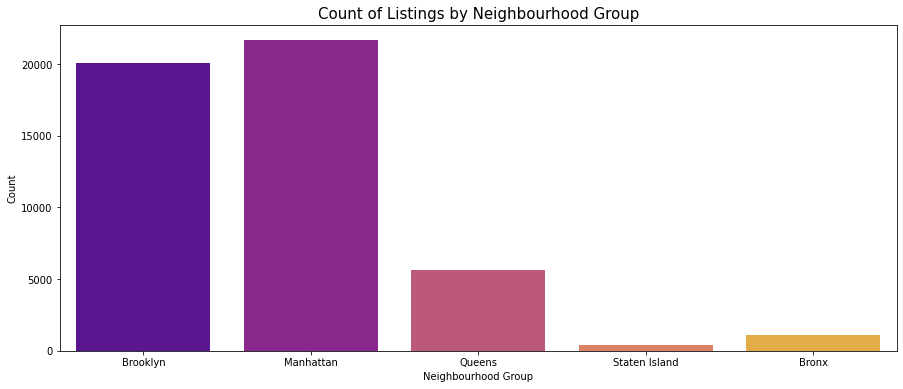

In [14]:
#visualising distribution
plt.figure(figsize=(15,6))
sns.countplot(data=airbnb, x='neighbourhood_group', palette='plasma')
plt.title('Count of Listings by Neighbourhood Group', fontsize=15)
plt.xlabel('Neighbourhood Group')
plt.ylabel("Count")

In [15]:
#looking at stats for price by neighbourhood group
airbnb_neighbourprice = airbnb[['host_id','neighbourhood_group','price']]
airbnb_neighbourprice = pd.pivot_table(airbnb_neighbourprice,index=['host_id'],columns='neighbourhood_group',values="price")
airbnb_neighbourprice = airbnb_neighbourprice[['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']]
airbnb_neighbourprice.describe()

neighbourhood_group,Brooklyn,Manhattan,Queens,Staten Island,Bronx
count,15965.000000,16577.000000,3983.000000,256.000000,789.000000
mean,128.295878,194.739170,106.062688,131.611575,87.272485
std,178.004408,293.036393,187.660918,327.376291,79.688268
min,10.000000,10.000000,10.000000,20.000000,10.000000
25%,65.000000,95.000000,57.291667,62.000000,50.000000
50%,99.000000,149.000000,80.000000,85.000000,70.000000
75%,150.000000,212.000000,120.000000,119.625000,100.000000
max,10000.000000,10000.000000,10000.000000,5000.000000,1300.000000


Text(0, 0.5, 'Count')

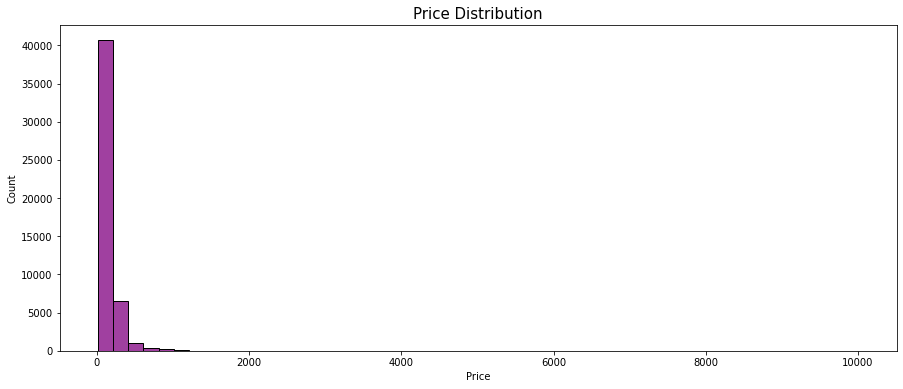

In [16]:
#Price histogram
plt.figure(figsize=(15,6))
sns.histplot(data=airbnb, x='price', binwidth = 200, color='purple')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price')
plt.ylabel("Count")

In [17]:
#finding 95th percentile for each neighbourhood group
airbnb_neighbourprice.quantile(0.95)

neighbourhood_group
Brooklyn         285.000000
Manhattan        450.000000
Queens           238.850000
Staten Island    275.000000
Bronx            182.733333
Name: 0.95, dtype: float64

In [18]:
#limiting data to remove outliers above 95th percentile to get rid of outliers
airbnb = airbnb[airbnb.price < 451]

Text(0, 0.5, 'Count')

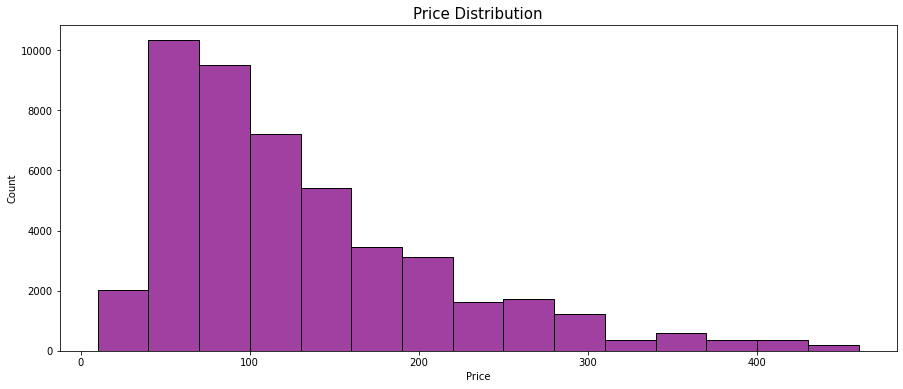

In [19]:
#Looking at price distribution after transformation
plt.figure(figsize=(15,6))
sns.histplot(data=airbnb, x='price', binwidth = 30, color='purple')
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Price')
plt.ylabel("Count")

Text(0, 0.5, 'Price')

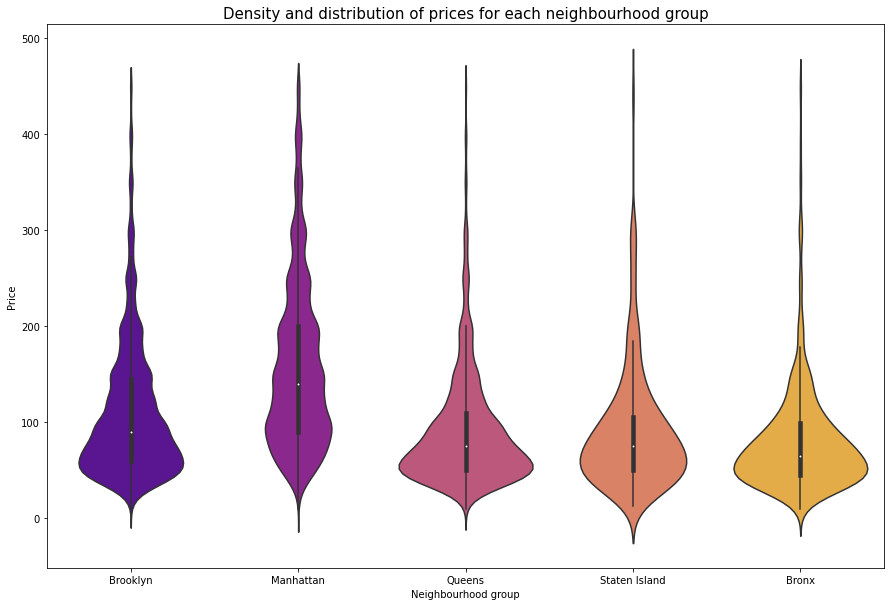

In [20]:
#looking at covariation of price and neighbourhood group
plt.figure(figsize=(15,10))
sns.violinplot(data=airbnb, x='neighbourhood_group', y='price', palette='plasma')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

### Room Type and Price

Text(0, 0.5, 'Count')

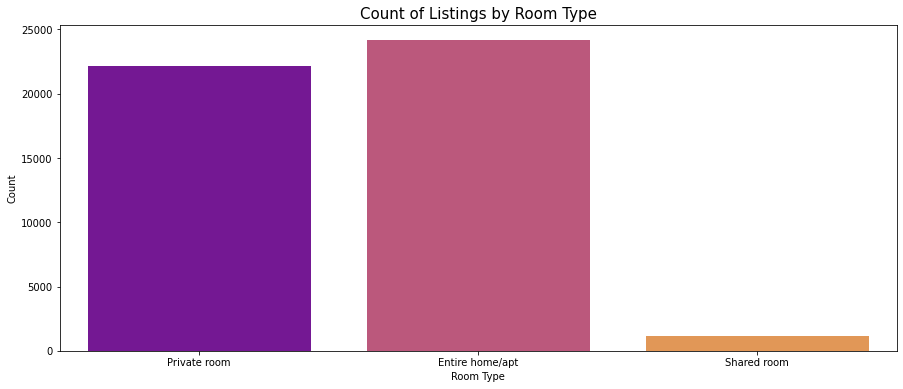

In [21]:
#room type distribution
plt.figure(figsize=(15,6))
sns.countplot(data=airbnb, x='room_type', palette='plasma')
plt.title('Count of Listings by Room Type', fontsize=15)
plt.xlabel('Room Type')
plt.ylabel("Count")

Text(0, 0.5, 'Price')

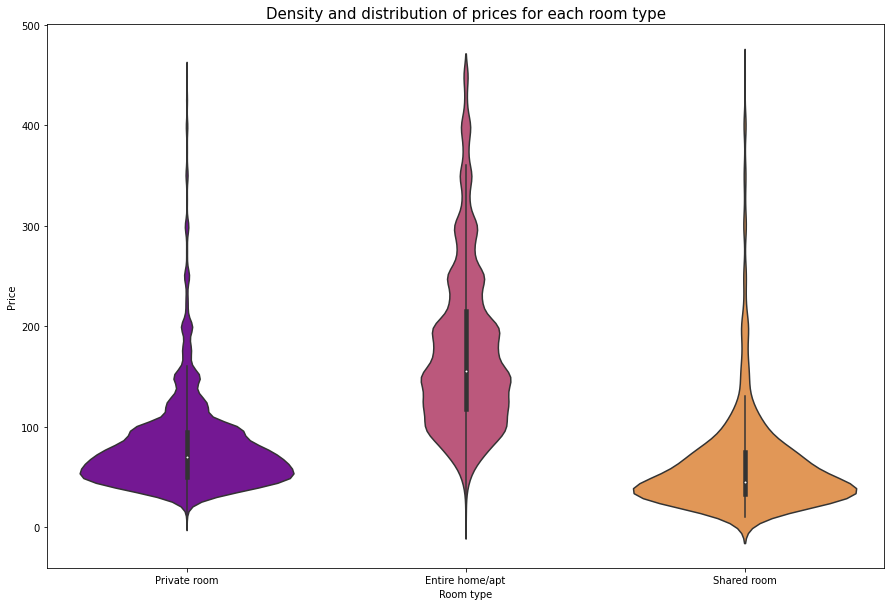

In [22]:
#covariation room type and price
plt.figure(figsize=(15,10))
sns.violinplot(data=airbnb, x='room_type', y='price', palette='plasma')
plt.title('Density and distribution of prices for each room type', fontsize=15)
plt.xlabel('Room type')
plt.ylabel("Price")

Text(0, 0.5, 'Availability')

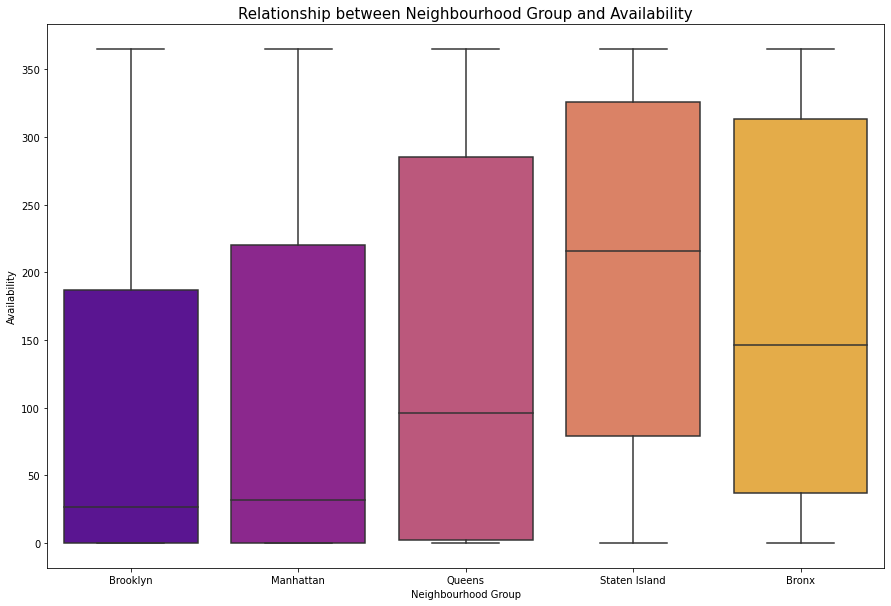

In [23]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=airbnb, x='neighbourhood_group', y='availability_365', palette='plasma')
plt.title('Relationship between Neighbourhood Group and Availability', fontsize=15)
plt.xlabel('Neighbourhood Group')
plt.ylabel("Availability")

Text(0, 0.5, 'Longitude')

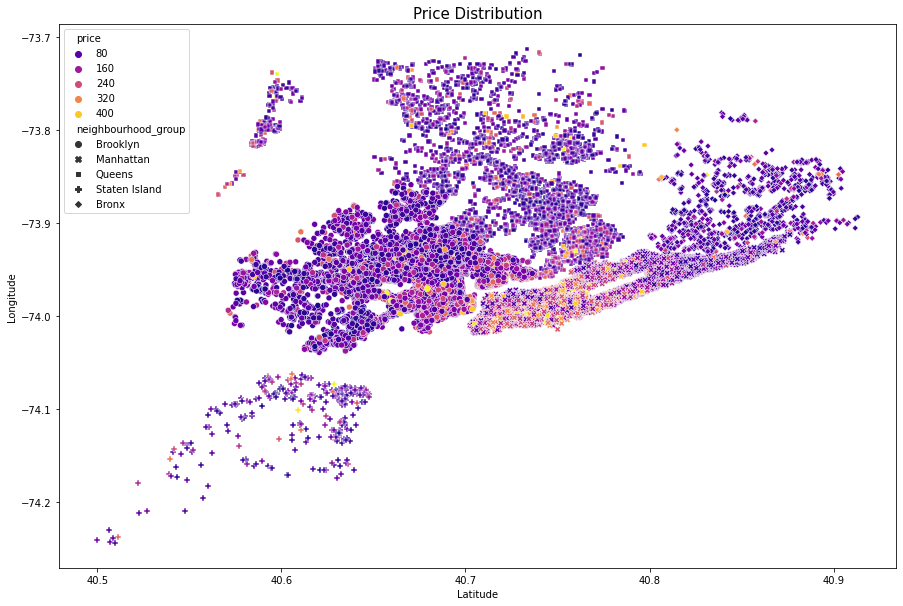

In [65]:
#Looking at price distribution after transformation
plt.figure(figsize=(15,10))
sns.scatterplot(data=airbnb, x='latitude', y = 'longitude', palette='plasma', hue = "price", style = "neighbourhood_group")
plt.title('Price Distribution', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")

## Preparing Data for Machine Learning

In [24]:
#function to return plots for the feature
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [25]:
#transforming features into normal distribution
airbnb['price_log'] = np.log(airbnb.price)

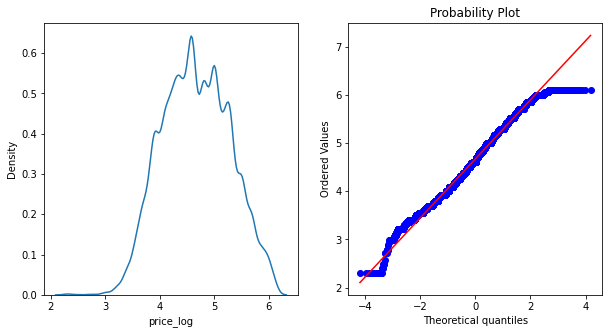

In [26]:
normality(airbnb,'price_log')

# Machine Learning

In [27]:
y = airbnb['price_log']
x = airbnb[['neighbourhood_group','latitude','longitude','room_type','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']]
x = pd.get_dummies(x, columns=['room_type','neighbourhood_group'])

In [28]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [29]:
#Split into train and test 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=212)

## XGBoost

### Hyperparameter Tuning

In [30]:
#Hyperparameter tuning to reduce overfitting

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train)
    

    pred = clf.predict(x_test)
    accuracy = r2_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [31]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.5997632346448653                                                                                                     
SCORE:                                                                                                                 
0.5906663319623306                                                                                                     
SCORE:                                                                                                                 
0.5994606356942804                                                                                                     
SCORE:                                                                                                                 
0.5960056331929193                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.611171811073785                                                                                                      
SCORE:                                                                                                                 
0.6090825319625999                                                                                                     
SCORE:                                                                                                                 
0.6076798416493541                                                                                                     
SCORE:                                                                                                                 
0.6102880894256673                                                                                                     
SCORE:                                  

In [32]:
#Get best hyperparameters
print(best_hyperparams)

{'colsample_bytree': 0.8873239019138885, 'gamma': 1.030259415647741, 'max_depth': 6.0, 'min_child_weight': 0.0, 'reg_alpha': 41.0, 'reg_lambda': 0.7745394693940159}


### XGBoost Model

In [33]:
#XGBoost Regressor model
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, gamma = 1, max_depth = 15, min_child_weight = 7, reg_alpha = 42, reg_lambda = 0.7936246860452796)

xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
#training data score
y_pred=xgb_model.predict(x_train)

r2_score(y_train,y_pred)

0.6269019781337717

In [35]:
#test data score
y_pred=xgb_model.predict(x_test)

r2_score(y_test,y_pred)

0.6355088652140702

## Descision Tree

### Hyperparameter Tuning

>1, train: 0.426, test: 0.436
>2, train: 0.493, test: 0.510
>3, train: 0.535, test: 0.546
>4, train: 0.559, test: 0.571
>5, train: 0.578, test: 0.589
>6, train: 0.597, test: 0.603
>7, train: 0.615, test: 0.611
>8, train: 0.633, test: 0.616
>9, train: 0.655, test: 0.613
>10, train: 0.677, test: 0.603
>11, train: 0.701, test: 0.587
>12, train: 0.728, test: 0.572
>13, train: 0.756, test: 0.544
>14, train: 0.785, test: 0.519
>15, train: 0.814, test: 0.496
>16, train: 0.841, test: 0.472
>17, train: 0.867, test: 0.447
>18, train: 0.892, test: 0.422
>19, train: 0.914, test: 0.396
>20, train: 0.932, test: 0.377


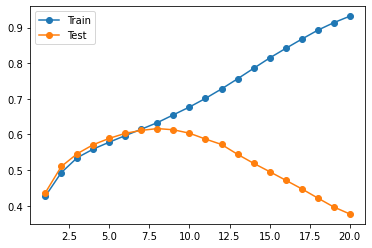

In [36]:
#hyperparameter tuning for regurlarisation to avoid overfitting

from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = [i for i in range(1, 21)]

# evaluate a decision tree for each depth
for i in values:
    model = DecisionTreeRegressor(max_depth=i)

# fit model on the training dataset
    model.fit(x_train, y_train)

# evaluate on the train dataset
    train_yhat = model.predict(x_train)
    train_acc = r2_score(y_train, train_yhat)
    train_scores.append(train_acc)

# evaluate on the test dataset
    test_yhat = model.predict(x_test)
    test_acc = r2_score(y_test, test_yhat)
    test_scores.append(test_acc)

# summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

### Decision Tree Model

In [37]:
#best max_depth is 8

dt_model = DecisionTreeRegressor(max_depth = 8)

dt_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=8)

In [38]:
y_pred=dt_model.predict(x_train)

r2_score(y_train,y_pred)

0.6332157913044769

In [39]:
y_pred=dt_model.predict(x_test)

r2_score(y_test,y_pred)

0.6162458294437771

## Random Forest

>1, train: 0.426, test: 0.436
>2, train: 0.502, test: 0.517
>3, train: 0.543, test: 0.555
>4, train: 0.569, test: 0.581
>5, train: 0.591, test: 0.601
>6, train: 0.613, test: 0.618
>7, train: 0.633, test: 0.631
>8, train: 0.653, test: 0.640
>9, train: 0.676, test: 0.646
>10, train: 0.700, test: 0.651
>11, train: 0.727, test: 0.653
>12, train: 0.754, test: 0.655
>13, train: 0.782, test: 0.656
>14, train: 0.809, test: 0.656
>15, train: 0.834, test: 0.656
>16, train: 0.858, test: 0.655
>17, train: 0.877, test: 0.655
>18, train: 0.894, test: 0.655
>19, train: 0.908, test: 0.653
>20, train: 0.918, test: 0.652


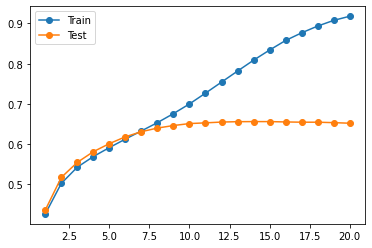

In [40]:
#hyperparameter tuning for regurlarisation to avoid overfitting

from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

train_scores, test_scores = list(), list()

#define max depths to evaluate
values = [i for i in range(1, 11)]

#evaluate a random forest for each depth
for i in values:
    model = RandomForestRegressor(max_depth=i)

#fit model on the training dataset
    model.fit(x_train, y_train)
    
#evaluate on the train dataset
    train_yhat = model.predict(x_train)
    train_acc = r2_score(y_train, train_yhat)
    train_scores.append(train_acc)

#evaluate on the test dataset
    test_yhat = model.predict(x_test)
    test_acc = r2_score(y_test, test_yhat)
    test_scores.append(test_acc)

#summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

#plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [41]:
#max depth of 9 is best

rf_model = RandomForestRegressor(max_depth = 9)

rf_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=9)

In [42]:
y_pred=rf_model.predict(x_train)

r2_score(y_train,y_pred)

0.6757628428692317

In [43]:
y_pred=rf_model.predict(x_test)

r2_score(y_test,y_pred)

0.646095955796288

## Shap

In [44]:
import shap
shap.initjs()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=212)

x_train_summary = shap.kmeans(x_train, 10)


## Shap - XGBoost

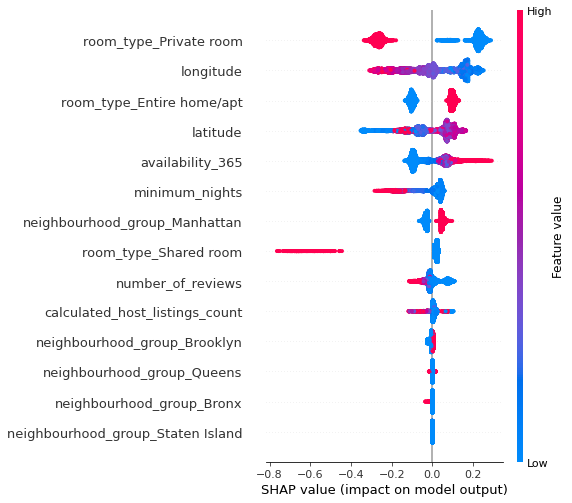

In [55]:
shap_xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, gamma = 1, max_depth = 15, min_child_weight = 7, reg_alpha = 42, reg_lambda = 0.7936246860452796)

shap_xgb_model.fit(x_train, y_train)

explainer = shap.TreeExplainer(shap_xgb_model)

shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)

## SHAP Decision Tree

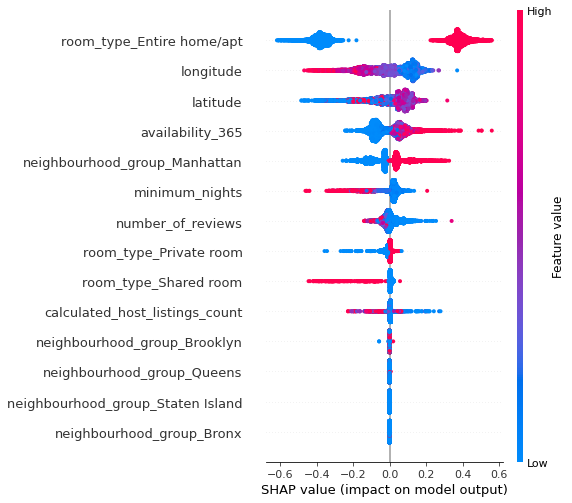

In [51]:
shap_dt_model = DecisionTreeRegressor(max_depth = 8)

shap_dt_model.fit(x_train, y_train)

explainer = shap.TreeExplainer(shap_dt_model)

shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)

## SHAP Random Forest

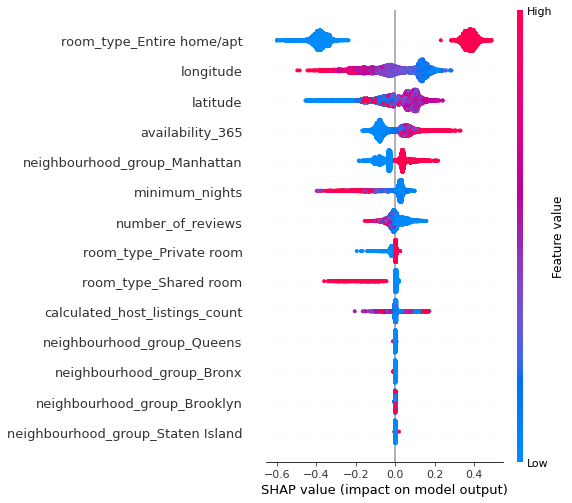

In [57]:
shap_rf_model = RandomForestRegressor(max_depth = 9)

shap_rf_model.fit(x_train, y_train)

explainer = shap.TreeExplainer(shap_rf_model)

shap_values = explainer.shap_values(x_test)

shap.summary_plot(shap_values, x_test)